In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime as DT
from tensorflow import keras
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense, BatchNormalization,Dropout
from tensorflow.keras import optimizers
import os
from matplotlib import pyplot as plt
from sklearn import svm, datasets

In [6]:
patients = pd.read_csv('./maindata/patients.csv')
allergies = pd.read_csv('./maindata/allergies.csv')

In [7]:
allergies = allergies[allergies.CATEGORY != 'medication']
print(len(allergies['CODE'].unique()))

15


In [8]:
AllergiesDetails = allergies[['CODE','DESCRIPTION','CATEGORY','REACTION1','DESCRIPTION1','SEVERITY1','REACTION2','DESCRIPTION2','SEVERITY2']]
AllergiesDetails = AllergiesDetails.drop_duplicates(subset='CODE',keep='last')

In [9]:
AllergiesDetails.to_csv('AllergiesList.csv',index=False)

In [10]:
allergies = allergies[['PATIENT','CODE','START']]

In [11]:
allergies = pd.merge(allergies,patients,how='left',left_on='PATIENT',right_on='Id')

In [12]:
allergies=allergies[['START','BIRTHDATE','LAT','LON','CODE']]
allergies['START'] = pd.to_datetime(allergies['START'], errors='coerce')
allergies['BIRTHDATE'] = pd.to_datetime(allergies['BIRTHDATE'], errors='coerce')

In [13]:
allergies['AGE'] = (allergies['START'] - allergies['BIRTHDATE']).astype('<m8[Y]')

In [14]:
allergies=allergies[['AGE','LAT','LON','CODE']]

In [15]:
allergies.to_csv('CleanedData.csv')

In [16]:
allergies.head()

,AGE,LAT,LON,CODE
0,1.0,41.930492,-71.003337,288328004
1,1.0,41.930492,-71.003337,84489001
2,1.0,41.930492,-71.003337,260147004
3,1.0,41.930492,-71.003337,264287008
4,1.0,41.930492,-71.003337,782576004


In [17]:
allergies_label = allergies.pop('CODE')

In [18]:
allergies_labels = pd.get_dummies(allergies_label,prefix="allergy")

In [19]:
allergies = pd.concat([allergies,allergies_labels],axis=1)

## Splitting Data in training and test

In [20]:
complete_train_dataset, temp_test_dataset = train_test_split(allergies,test_size=0.1)
complete_test_dataset,complete_valid_dataset = train_test_split(temp_test_dataset,test_size=0.5)

In [21]:
train_dataset = complete_train_dataset.iloc[:,0:3]
train_labels = complete_train_dataset.iloc[:,3:]

In [22]:
test_dataset = complete_test_dataset.iloc[:,0:3]
test_labels = complete_test_dataset.iloc[:,3:]

In [23]:
valid_dataset = complete_valid_dataset.iloc[:,0:3]
valid_labels = complete_valid_dataset.iloc[:,3:]

#### Normalizing data

In [24]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()


In [25]:
def norm(x):
    return (x-train_stats['mean'])/train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_valid_data = norm(valid_dataset)

In [26]:
print(normed_test_data.shape[1])
print(train_labels.shape[1])

3
15


In [27]:
def buildModel():
    model = Sequential()
    model.add(Dense(27,input_shape=(normed_train_data.shape[1],)))
    model.add(Dense(9,activation='relu'))
    model.add(Dense(train_labels.shape[1],activation='softmax'))
    learning_rate = 0.0001
    optimizer = optimizers.Adam(learning_rate)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model

EPOCHS = 1000
batch_size = 10

model = buildModel()
# model.summary()

In [30]:
checkpoint_path = "training_finalData_take2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

history = model.fit(
    normed_train_data,
    train_labels,
    batch_size=batch_size,
    epochs=EPOCHS,
    verbose=1,
    shuffle=True,
    callbacks=[cp_callback],
    steps_per_epoch = int(normed_train_data.shape[0]/batch_size),
    validation_data=(normed_valid_data,valid_labels)
)
model.save('final_model/final_model')

ValueError: y should be a 1d array, got an array of shape (6852, 15) instead.

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
995,2.503985,0.135779,2.529528,0.115486,995
996,2.494463,0.147179,2.527795,0.120735,996
997,2.500891,0.139871,2.529802,0.115486,997
998,2.492915,0.141187,2.529576,0.112861,998
999,2.503837,0.140310,2.528656,0.118110,999


In [174]:
example_batch = normed_test_data[:10]
example_result = model.predict(example_batch)
example_result

array([[2.2077847e-02, 1.6623808e-01, 7.7430243e-03, 3.7602786e-02,
        6.6380084e-02, 1.5480835e-03, 1.5387456e-01, 1.7002632e-01,
        7.3970951e-02, 7.3710647e-03, 6.4563979e-03, 3.3893203e-03,
        2.2757135e-02, 2.1023498e-01, 5.0329439e-02],
       [9.1147669e-02, 2.7630413e-01, 3.2107397e-03, 7.4900629e-04,
        8.6617045e-02, 1.5829600e-03, 2.2268233e-01, 9.8922737e-02,
        2.5888509e-03, 4.4297238e-04, 3.5255142e-02, 5.3509343e-02,
        2.8919084e-03, 1.2154943e-01, 2.5457167e-03],
       [1.9332273e-02, 2.6413819e-01, 6.9224479e-04, 3.6999219e-05,
        6.0292810e-02, 1.6346797e-03, 2.3880020e-01, 2.1038590e-02,
        3.8685565e-05, 6.6196785e-04, 3.4070730e-02, 2.9512677e-01,
        5.2356206e-02, 1.1641784e-02, 1.3776460e-04],
       [5.0597295e-02, 1.3899317e-01, 3.0273737e-03, 7.4515869e-03,
        1.1531734e-01, 2.1421628e-03, 1.6676916e-01, 2.0830250e-01,
        8.8252332e-03, 3.0498449e-03, 1.3958870e-02, 3.0206744e-02,
        1.0370595e-02,

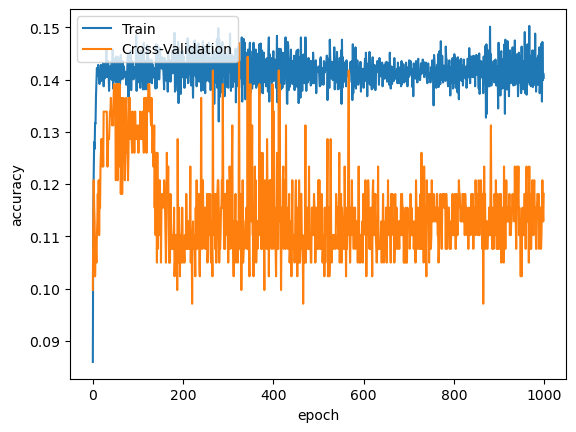

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

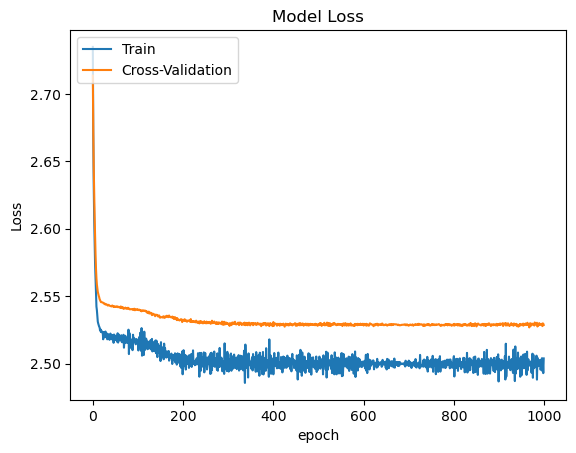

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

In [28]:
loss, accuracy = model.evaluate(normed_train_data,train_labels, verbose=1)
print("Accuracy    :{:5.2f}".format(accuracy))

215/215 [==============================] - 0s 384us/step - loss: 2.4986 - accuracy: 0.1427
Accuracy    : 0.14


In [29]:
loss, accuracy = model.evaluate(normed_valid_data,valid_labels, verbose=1)
print("Accuracy    :{:5.2f}".format(accuracy))

12/12 [==============================] - 0s 797us/step - loss: 2.5287 - accuracy: 0.1181
Accuracy    : 0.12


In [30]:
loss, accuracy = model.evaluate(normed_test_data,test_labels, verbose=1)
print("Accuracy    :{:5.2f}".format(accuracy))

12/12 [==============================] - 0s 668us/step - loss: 2.4720 - accuracy: 0.1732
Accuracy    : 0.17
